In [2]:
import os
import sys
import argparse
import numpy as np
import pandas as pd
import nibabel as nib    
from pathlib import Path
from surface_distance import metrics
from tqdm import tqdm



def sensitivity_and_specificity(mask_gt, mask_pred):
    """ Computes sensitivity and specificity
     sensitivity  = TP/(TP+FN)
     specificity  = TN/(TN+FP) """
    volume_sum = mask_gt.sum() + mask_pred.sum()
    tp = (mask_gt & mask_pred).sum()
    tn = (~mask_gt & ~mask_pred).sum()
    fp = (~mask_gt & mask_pred).sum()
    fn = (mask_gt & ~mask_pred).sum()
#     TP/(TP+FP) - precision; TP/(TP+FN) - recall
    return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)


def calculate_metrics_brats(true_mask, pred_mask, ids, spaces):
    """ Takes two file locations as input and validates surface distances.
    Be careful with dimensions of saved `pred` it should be 3D.
    
    """
    
    _columns = ['Ids', 'Dice_all','Dice_0', 'Dice_1', 'Dice_2', 'Dice_3',
               'Hausdorff95_all', 'Hausdorff95_0', 'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_4',
               'Sensitivity_all','Sensitivity_0', 'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_4',
               'Specificity_all','Specificity_0', 'Specificity_1', 'Specificity_2', 'Specificity_4',
               'Surface_dice_all','Surface_dice_0', 'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_4',
               'Precision_all', 'Precision_0', 'Precision_1', 'Precision_2', 'Precision_4']
    
    df = pd.DataFrame(columns = _columns)
    df.at[0,'Ids'] = ids
    #class 1
    distances = metrics.compute_surface_distances((true_mask[0,:,:,:]==1), (pred_mask[0,:,:,:]==1), spaces)
    df.at[0,'Dice_1'] = metrics.compute_dice_coefficient((true_mask[0,:,:,:]==1), (pred_mask[0,:,:,:]==1))
    df.at[0,'Surface_dice_1'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_1'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec = sensitivity_and_specificity((true_mask[0,:,:,:]==1), (pred_mask[0,:,:,:]==1))
    df.at[0,'Sensitivity_1'] = sens
    df.at[0,'Precision_1'] = precision
    df.at[0,'Specificity_1'] = spec
    #class 2
    distances = metrics.compute_surface_distances((true_mask[1,:,:,:]==1), (pred_mask[1,:,:,:]==1), spaces)
    df.at[0,'Dice_2'] = metrics.compute_dice_coefficient((true_mask[1,:,:,:]==1), (pred_mask[1,:,:,:]==1))
    df.at[0,'Surface_dice_2'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_2'] = metrics.compute_robust_hausdorff(distances, 95)
    sens,precision, spec= sensitivity_and_specificity((true_mask[1,:,:,:]==1), (pred_mask[1,:,:,:]==1))
    df.at[0,'Sensitivity_2'] = sens
    df.at[0,'Precision_2'] = precision
    df.at[0,'Specificity_2'] = spec
    #class 3
    distances = metrics.compute_surface_distances((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1), spaces)
    df.at[0,'Dice_4'] = metrics.compute_dice_coefficient((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1))
    df.at[0,'Surface_dice_4'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_4'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec= sensitivity_and_specificity((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1))
    df.at[0,'Sensitivity_4'] = sens
    df.at[0,'Precision_4'] = precision
    df.at[0,'Specificity_4'] = spec
    return df

def get_stats(preds, target, class_idx):
        tp = torch.logical_and(preds == class_idx, target == class_idx).sum()
        fn = torch.logical_and(preds != class_idx, target == class_idx).sum()
        fp = torch.logical_and(preds == class_idx, target != class_idx).sum()
        return tp, fn, fp

    
def compute_stats_brats( p, y):
        scores = torch.zeros(3, device=p.device, dtype=torch.float32)
        p = (torch.sigmoid(p) > 0.5).int()
        y_wt, y_tc, y_et = y > 0, ((y == 1) + (y == 3)) > 0, y == 3
        y = torch.stack([y_wt, y_tc, y_et], dim=1)

        for i in range(3):
            p_i, y_i = p[:, i], y[:, i]
            if (y_i != 1).all():
                # no foreground class
                scores[i - 1] += 1 if (p_i != 1).all() else 0
                continue
            tp, fn, fp = get_stats(p_i, y_i, 1)
            denom = (2 * tp + fp + fn).to(torch.float)
            score_cls = (2 * tp).to(torch.float) / denom if torch.is_nonzero(denom) else 0.0
            scores[i - 1] += score_cls
        return scores
    
def calculate_metrics(path_to_pred, path_to_target, spaces = True, name_csv='dice_metrics.csv', path_csv_all = '/home/polina/glioma/all_dice_metrics.csv'  ):
    
    """ 
    - path_to_pred - path to folder with predict subjects
    - path_to_target - path to folder with target subjects
    - name_pred - name for prediction, ex -brainTumorMask_SRI.nii.gz
    - name_target - name for targets, ex -GTV_to_SRI.nii.gz
    - spaces - if false - [1,1,1]
    - name_csv - name files for each subjects
    - path_csv_all - path to the main file with metrics for each subjects
    """
    _columns = ['Ids', 'Dice_all','Dice_0', 'Dice_1', 'Dice_2', 'Dice_3',
               'Hausdorff95_all', 'Hausdorff95_0', 'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_4',
               'Sensitivity_all','Sensitivity_0', 'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_4',
               'Specificity_all','Specificity_0', 'Specificity_1', 'Specificity_2', 'Specificity_4',
               'Surface_dice_all','Surface_dice_0', 'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_4',
               'Precision_all', 'Precision_0', 'Precision_1', 'Precision_2', 'Precision_4']
    af_all = pd.DataFrame(columns = _columns)
    pred_folder = Path(path_to_pred)
    target_folder = Path(path_to_target)
    for ids in tqdm(os.listdir(pred_folder)):
        sub = ids[:-4]
        targets = nib.load(target_folder /  f'{sub}_seg.nii.gz').get_fdata()
        y_wt, y_tc, y_et = targets > 0, ((targets == 1) + (targets == 3)) > 0, targets == 3
        targets = np.stack([y_wt, y_tc, y_et], axis=0).astype(int)
        predictions = np.load((os.path.join(path_pred, ids)))
        spaces = [1,1,1]
        pred = np.round(predictions, 0)
        pred = np.transpose(pred, (0, 3, 2, 1))
        df=calculate_metrics_brats(targets.astype('int'), pred.astype('int'), sub, spaces)
#         score = compute_stats_brats(predictions, )
#         compute_stats_brats( p, y)
        af_all = af_all.append(df)
    af_all.to_csv('all_metrics_brats3fold_2.csv')  
    print(af_all.mean())

In [11]:
path_pred= '/results/brats_infer/predictions_epoch=117-dice_mean=92_10_task=11_fold=3_tta'
path_target='/data/BraTS2021_val/labels/'
calculate_metrics(path_pred, path_target)

 15%|███████████████████▏                                                                                                             | 62/417 [02:34<13:21,  2.26s/it]/opt/conda/lib/python3.8/site-packages/surface_distance/metrics.py:421: RuntimeWarning: invalid value encountered in double_scalars
  surface_dice = (overlap_gt + overlap_pred) / (
/tmp/ipykernel_814/2778257941.py:23: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [16:27<00:00,  2.37s/it]

Dice_all                 NaN
Dice_0                   NaN
Dice_1              0.945925
Dice_2              0.946004
Dice_3                   NaN
Hausdorff95_all          NaN
Hausdorff95_0            NaN
Hausdorff95_1       3.719388
Hausdorff95_2            inf
Hausdorff95_4            inf
Sensitivity_all          NaN
Sensitivity_0            NaN
Sensitivity_1       0.939036
Sensitivity_2       0.941432
Sensitivity_4       0.901269
Specificity_all          NaN
Specificity_0            NaN
Specificity_1       0.999674
Specificity_2       0.999861
Specificity_4       0.999856
Surface_dice_all         NaN
Surface_dice_0           NaN
Surface_dice_1      0.916308
Surface_dice_2      0.932039
Surface_dice_4      0.935278
Precision_all            NaN
Precision_0              NaN
Precision_1         0.956469
Precision_2         0.957439
Precision_4         0.914343
Dice_4              0.893686
dtype: float64


In [2]:
from scipy.ndimage import measurements
def to_lbl(pred):
    enh = pred[2]
    c1, c2, c3 = pred[0] > 0.5, pred[1] > 0.5, pred[2] > 0.5
    pred = (c1 > 0).astype(np.uint8)
    pred[(c2 == False) * (c1 == True)] = 2
    pred[(c3 == True) * (c1 == True)] = 4

    components, n = measurements.label(pred == 4)
    for et_idx in range(1, n + 1):
        _, counts = np.unique(pred[components == et_idx], return_counts=True)
        if 1 < counts[0] and counts[0] < 8 and np.mean(enh[components == et_idx]) < 0.9:
            pred[components == et_idx] = 1

    et = pred == 4
    if 0 < et.sum() and et.sum() < 73 and np.mean(enh[et]) < 0.9:
        pred[et] = 1
    pred = np.transpose(pred, (2, 1, 0)).astype(np.uint8)
    return pred


def prepare_preditions(e):
    fname = e[0].split("/")[-1].split(".")[0]
    preds = [np.load(f) for f in e]
    p = to_lbl(np.mean(preds, 0))

In [ ]:
!cd /data/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

n, z = 5, 75
data = sorted(glob("/results/brats_infer/predictions_epoch=117-dice_mean=92_10_task=11_fold=3_tta/*.npy"))
for i in range(n):
    fname = data[i].split("/")[-1].split(".")[0]
    print(fname)
    img = nib.load(f"/data/BraTS2021_val/images/{fname}.nii.gz").get_fdata().astype(np.float32)
    label = nib.load(f"/data/BraTS2021_val/labels/{fname}_seg.nii.gz").get_fdata().astype(np.uint8)[:, :, z]
    pred = np.load(data[i])
    p = to_lbl(np.round(pred, 0))[:, :, z]
    imgs = [img[:, :, z, i] for i in [0, 3]] + [p] + [label] +  [label==1] +  [label==2] +  [label==4] 
    
    fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(12, 12))
    for i in range(7):
        if i < 2:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()

IndexError: list index out of range

# All data 

In [14]:
!cd  /home/polina/DeepLearningExamples/PyTorch/Segmentation/nnUNet/results/3_fold_brats_2021/fold-2/checkpoints && ls

'epoch=111-dice_mean=90.69.ckpt'  'epoch=34-dice_mean=89.24.ckpt'
'epoch=113-dice_mean=90.69.ckpt'  'epoch=39-dice_mean=89.47.ckpt'
'epoch=116-dice_mean=90.62.ckpt'  'epoch=40-dice_mean=89.69.ckpt'
'epoch=120-dice_mean=90.63.ckpt'  'epoch=43-dice_mean=87.94.ckpt'
'epoch=121-dice_mean=90.77.ckpt'  'epoch=98-dice_mean=90.80.ckpt'
'epoch=136-dice_mean=90.66.ckpt'   last.ckpt
'epoch=30-dice_mean=89.44.ckpt'


In [13]:
! cd /results/brats_infer && ls

 fold-0   fold-2
 fold-1  'predictions_epoch=117-dice_mean=92_10_task=11_fold=3_tta'


In [ ]:
!cd /data/ && ls

In [1]:
!cd ../ && export CUDA_VISIBLE_DEVICES=1 && python main.py --exec_mode predict --task 11 --data /data/11_3d --brats --dim 3 --fold 2 --nfolds 3 --ckpt_path /home/polina/DeepLearningExamples/PyTorch/Segmentation/nnUNet/results/3_fold_brats_2021/fold-2/checkpoints/epoch=98-dice_mean=90.80.ckpt --results /results/brats_infer/fold-2 --amp --tta --save_preds

Global seed set to 1
0 training, 0 validation, 1251 test examples
Filters: [64, 96, 128, 192, 256, 384, 512],
Kernels: [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
Strides: [[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
Testing: 100%|████████████████████████████| 1251/1251 [2:03:45<00:00,  5.94s/it]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


In [11]:
path_pred= '/results/brats_infer/fold-0/predictions_epoch=135-dice_mean=90_62_task=11_fold=0_tta'
path_target='/data/BraTS2021_train/labels/'
calculate_metrics(path_pred, path_target)

  3%|█▏                                       | 36/1251 [01:15<43:22,  2.14s/it]/opt/conda/lib/python3.8/site-packages/surface_distance/metrics.py:421: RuntimeWarning: invalid value encountered in double_scalars
  surface_dice = (overlap_gt + overlap_pred) / (
/tmp/ipykernel_527/415984070.py:23: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)
100%|█████████████████████████████████████| 1251/1251 [1:32:26<00:00,  4.43s/it]

Dice_all                 NaN
Dice_0                   NaN
Dice_1              0.940985
Dice_2              0.932818
Dice_3                   NaN
Hausdorff95_all          NaN
Hausdorff95_0            NaN
Hausdorff95_1       4.073485
Hausdorff95_2            inf
Hausdorff95_4            inf
Sensitivity_all          NaN
Sensitivity_0            NaN
Sensitivity_1       0.935805
Sensitivity_2       0.931208
Sensitivity_4       0.895279
Specificity_all          NaN
Specificity_0            NaN
Specificity_1       0.999584
Specificity_2       0.999830
Specificity_4       0.999835
Surface_dice_all         NaN
Surface_dice_0           NaN
Surface_dice_1      0.902042
Surface_dice_2      0.912690
Surface_dice_4      0.927982
Precision_all            NaN
Precision_0              NaN
Precision_1         0.951919
Precision_2         0.946570
Precision_4         0.905185
Dice_4              0.886609
dtype: float64


In [6]:
path_pred= '/results/brats_infer/fold-2/predictions_epoch=98-dice_mean=90_80_task=11_fold=2_tta'
path_target='/data/BraTS2021_train/labels/'
calculate_metrics(path_pred, path_target)

  0%|▏                                                                                                   | 2/1251 [00:07<1:13:03,  3.51s/it]/tmp/ipykernel_462/2657038760.py:23: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)
  3%|██▉                                                                                                  | 36/1251 [01:15<39:49,  1.97s/it]/opt/conda/lib/python3.8/site-packages/surface_distance/metrics.py:421: RuntimeWarning: invalid value encountered in double_scalars
  surface_dice = (overlap_gt + overlap_pred) / (
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1251/1251 [47:34<00:00,  2.28s/it]

Dice_all                 NaN
Dice_0                   NaN
Dice_1              0.937800
Dice_2              0.929824
Dice_3                   NaN
Hausdorff95_all          NaN
Hausdorff95_0            NaN
Hausdorff95_1       4.876526
Hausdorff95_2            inf
Hausdorff95_4            inf
Sensitivity_all          NaN
Sensitivity_0            NaN
Sensitivity_1       0.924076
Sensitivity_2       0.933571
Sensitivity_4       0.902262
Specificity_all          NaN
Specificity_0            NaN
Specificity_1       0.999655
Specificity_2       0.999804
Specificity_4       0.999792
Surface_dice_all         NaN
Surface_dice_0           NaN
Surface_dice_1      0.897337
Surface_dice_2      0.907932
Surface_dice_4      0.924831
Precision_all            NaN
Precision_0              NaN
Precision_1         0.957598
Precision_2         0.939883
Precision_4         0.893179
Dice_4              0.882655
dtype: float64


BraTS2021_00000
(3, 155, 240, 240)
(240, 240, 1)
(240, 240, 1)


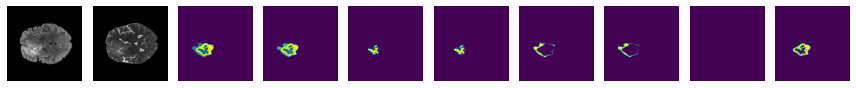

BraTS2021_00002
(3, 155, 240, 240)
(240, 240, 1)
(240, 240, 1)


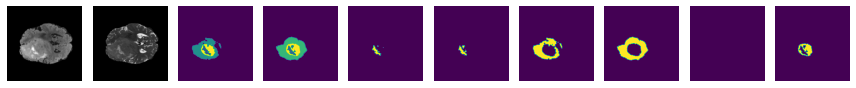

BraTS2021_00003
(3, 155, 240, 240)
(240, 240, 1)
(240, 240, 1)


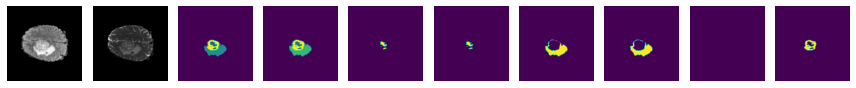

BraTS2021_00005
(3, 155, 240, 240)
(240, 240, 1)
(240, 240, 1)


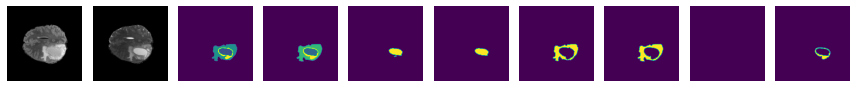

BraTS2021_00006
(3, 155, 240, 240)
(240, 240, 1)
(240, 240, 1)


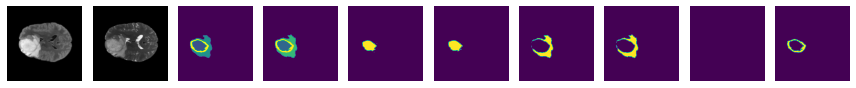

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

n, z = 5, 75
data = sorted(glob("/results/brats_infer/fold-0/predictions_epoch=135-dice_mean=90_62_task=11_fold=0_tta/*.npz"))
for i in range(n):
    fname = data[i].split("/")[-1].split(".")[0]
    print(fname)
    img = nib.load(f"/data/BraTS2021_train/images/{fname}.nii.gz").get_fdata().astype(np.float32)
    label = nib.load(f"/data/BraTS2021_train/labels/{fname}_seg.nii.gz").get_fdata().astype(np.uint8)
    z = np.argsort(label.sum(axis=(0,1)))[-1:]
    label = label[:, :, z]
    pred = np.load(data[i])['arr_0']
    print(pred.shape), print(label.shape)
    p = to_lbl(np.round(pred, 0))[:, :, z]
    print(p.shape)
    imgs = [img[:, :, z, i] for i in [0, 3]] + [p] + [label]+  [p==1] +  [label==1] +  [p==2] +  [label==2] +  [p==3] +  [label==3] 
   
    fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(12, 12))
    for i in range(10):
        if i < 2:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()

In [15]:
!cd /data/private_data/brats_pipeline_out/1019_18/check_gost_gtv_to_ref.nii.gz && ls

FL_rai.nii.gz		  T1_to_SRI_brain.nii.gz
FL_rai_n4.nii.gz	  T1_to_T1CE.mat
FL_raw.nii.gz		  T2_rai.nii.gz
FL_to_SRI.nii.gz	  T2_rai_n4.nii.gz
FL_to_SRI_brain.nii.gz	  T2_raw.nii.gz
FL_to_T1CE.mat		  T2_to_SRI.nii.gz
T1CE_rai.nii.gz		  T2_to_SRI_brain.nii.gz
T1CE_rai_n4.nii.gz	  T2_to_T1CE.mat
T1CE_raw.nii.gz		  brainMask_SRI.nii.gz
T1CE_to_SRI.mat		  brainTumorMask_SRI.nii.gz
T1CE_to_SRI.nii.gz	  check_gost_gtv_to_ref.nii.gz
T1CE_to_SRI_brain.nii.gz  dice_hausdorff_metrics_captk.csv
T1_rai.nii.gz		  dmOut_skull
T1_rai_n4.nii.gz	  dmOut_tumor
T1_raw.nii.gz		  seg_to_ref.nii.gz
T1_to_SRI.nii.gz


In [7]:
label = nib.load("/data/brats/BraTS2021_00000/BraTS2021_00000_seg.nii.gz").get_fdata().astype(np.uint8)

In [8]:
label.shape

(240, 240, 155)

In [16]:
l = nib.load("/data/private_data/brats_pipeline_out/1019_18/check_gost_gtv_to_ref.nii.gz").get_fdata().astype(np.uint8)

In [18]:
l.shape

(240, 240, 155)

In [6]:
!cd /data&& ls

11_3d		 EGD	    brats_hd_glio  rsna-pneumonia-detection-challenge
14_3d		 EGD_train  candid-ptx	   tomsk_xray
BraTS2021_train  brats	    private_data


In [7]:
img = np.load(f"/data/11_3d/{fname}_x.npy").astype(np.float32)
label = np.load(f"/data/11_3d/{fname}_y.npy").astype(np.uint8)
meta =  np.load(f"/data/11_3d/{fname}_meta.npy").astype(np.uint8)
orig_lbl =  np.load(f"/data/11_3d/{fname}_orig_lbl.npy").astype(np.uint8)

In [8]:
img.shape, label.shape, meta.shape, orig_lbl.shape

((5, 136, 177, 134), (1, 136, 177, 134), (4, 3), (1, 136, 177, 134))

In [9]:
meta

array([[  0,  36,  49],
       [136, 213, 183],
       [155, 240, 240],
       [136, 177, 134]], dtype=uint8)

In [11]:
img = nib.load(f"/data/BraTS2021_train/images/{fname}.nii.gz").get_fdata().astype(np.float32)
label = nib.load(f"/data/BraTS2021_train/labels/{fname}_seg.nii.gz").get_fdata().astype(np.uint8)

In [12]:
img.shape, label.shape,

((240, 240, 155, 4), (240, 240, 155))

In [14]:
155-134, 240 - 177, 240 -136

(21, 63, 104)